In [2419]:
# %pip install cv2

# CC3182 – Visión por Computadora
# Laboratorio 2

Link del respositorio: https://github.com/Czar272/lab2_VxC.git

## Integrantes:
 - Francis Aguilar
 - César Lopez
 - Jose Marchena


In [2420]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6,6)


# Task 1

Usted trabaja para una empresa de imágenes satelitales. Una de las cámaras en órbita tiene una
interferencia electrónica que genera un ruido sinusoidal (patrón de rayas diagonales) sobre las fotografías
de la superficie terrestre. Los filtros espaciales tradicionales (Gaussian Blur) destruyen los detalles
geográficos necesarios. Por ello usted ha decido idear una solución tomando como base fotografías que
tiene a mano con el mismo problema previo a implementar la solución real. Con esto en mente, realice:

1. Cargue la imagen periodic_noise.jpg en escala de grises.
2. Calcule la Transformada Discreta de Fourier (DFT) y desplace el componente de frecuencia cero al
centro.
3. Muestre el Espectro de Magnitud en escala logarítmica.
4. Identifique visualmente los "picos" de energía que no corresponden a la información natural de la
imagen (puntos brillantes fuera del centro).
5. Cree una máscara (Notch Filter) que bloquee específicamente esas frecuencias parásitas
(haciéndolas cero), pero preserve el resto del espectro, incluyendo el componente DC.
6. Aplique la Transformada Inversa (IDFT) para recuperar la imagen espacial.

In [2421]:
img = cv2.imread('periodic_noise.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title('Imagen original con ruido periódico')
plt.axis('off')


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

In [2422]:
fft = np.fft.fft2(img)
fft_shift = np.fft.fftshift(fft)


In [2423]:
magnitude_spectrum = 20 * np.log(np.abs(fft_shift) + 1)

plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Espectro de magnitud (escala logarítmica)')
plt.axis('off')


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

### Identificación de picos de energía no deseados

En el espectro de magnitud se observa un componente brillante central, correspondiente al componente DC de la imagen.  
Además, aparecen pares de puntos brillantes simétricos alejados del centro del espectro.

Estos picos no corresponden a la información natural de la imagen, sino que son característicos de un ruido periódico de tipo sinusoidal en el dominio espacial.  
La simetría de estos picos es consecuencia directa de la Transformada de Fourier aplicada a una señal real.


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

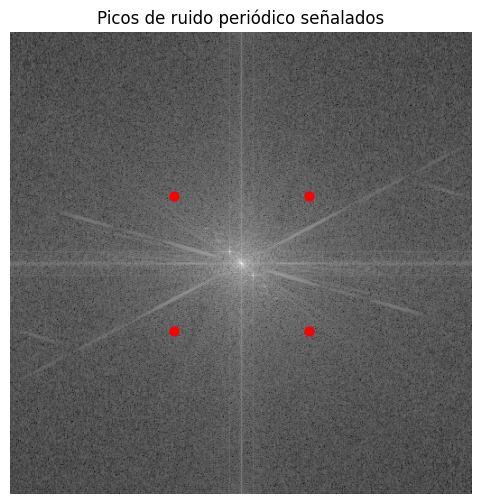

In [2424]:
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

offset = 75

plt.imshow(magnitude_spectrum, cmap='gray')
plt.scatter(
    [ccol-offset, ccol+offset, ccol-offset, ccol+offset],
    [crow-offset, crow+offset, crow+offset, crow-offset],
    c='red', s=40
)
plt.title('Picos de ruido periódico señalados')
plt.axis('off')


In [ ]:
mask = np.ones((rows, cols), np.uint8)

length = 64
width = 7

directions = [
    (-1, -1),
    (-1,  1),
    ( 1, -1),
    ( 1,  1)
]


for dr, dc in directions:
    for i in range(offset - length, offset + length):
        r = crow + dr * i
        c = ccol + dc * i
        mask[
            r - width//2 : r + width//2,
            c - width//2 : c + width//2
        ] = 0
        
plt.imshow(mask, cmap='gray')
plt.title('Máscara Notch alineada con el ruido')
plt.axis('off')


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

In [2426]:
filtered_fft = fft_shift * mask

ifft_shift = np.fft.ifftshift(filtered_fft)
img_filtered = np.fft.ifft2(ifft_shift)
img_filtered = np.abs(img_filtered)


In [2427]:
plt.imshow(img_filtered, cmap='gray')
plt.title('Imagen restaurada tras Notch Filter')
plt.axis('off')


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

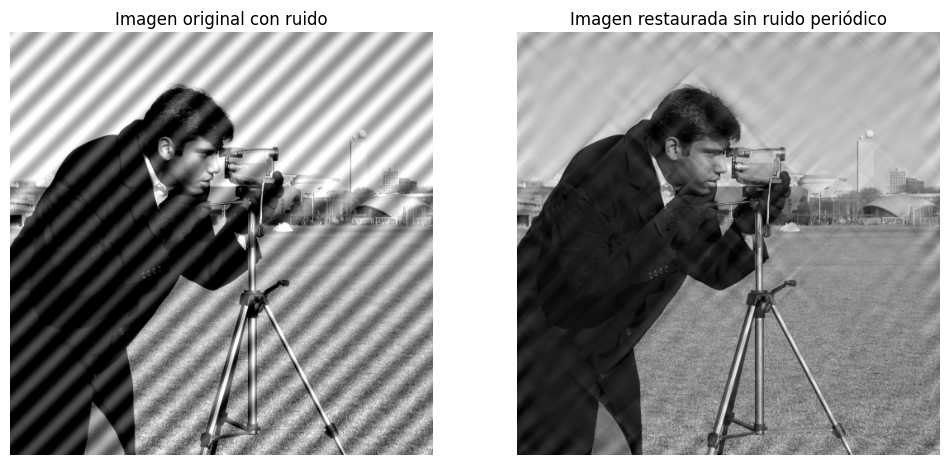

In [2428]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Imagen original con ruido')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_filtered, cmap='gray')
plt.title('Imagen restaurada sin ruido periódico')
plt.axis('off')

plt.show()


### ¿Por qué un filtro de promedio (average filter) 5×5 no es una buena solución?

Un filtro de promedio en el dominio espacial actúa como un filtro pasa-bajas, atenuando todas las altas frecuencias de la imagen sin distinción.  
En este problema, el ruido periódico corresponde a frecuencias muy específicas, mientras que los detalles geográficos relevantes también contienen componentes de alta frecuencia.

Aplicar un average filter 5×5 reduciría parcialmente el ruido, pero al mismo tiempo produciría una imagen borrosa y degradaría bordes y texturas importantes.

En contraste, el filtrado en el dominio de la frecuencia mediante un filtro Notch permite eliminar únicamente las frecuencias asociadas al ruido sinusoidal, preservando los detalles estructurales de la imagen.  
Por esta razón, el enfoque en frecuencia es más adecuado para este problema específico.


# Task 2
Está desarrollando un sistema biométrico de seguridad. El sensor de huellas dactilares está sucio y
produce imágenes binarias con dos tipos de defectos:
1. Pequeños puntos blancos en los valles negros de la huella (Ruido Sal)
2. Las “crestas” de la huella tienen pequeñas roturas que impiden que el algoritmo de matching
funcione (grietas).
Con esto en mente realice:

Con esto en mente realice:
1. Cargue la imagen fingerprint_noisy.png. Asegúrese de que sea binaria.
2. Aplique una operación morfológica para eliminar el ruido blanco sin destruir las crestas de la
huella. (Seleccione entre Erosión, Dilatación, Apertura o Cierre).
3. Aplique una segunda operación secuencial para conectar las grietas en las crestas de la huella.
4. Muestre la imagen original, la imagen tras el paso 2, y la imagen final.

In [2429]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('fingerprint_noisy.png', cv2.IMREAD_GRAYSCALE)
_, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # esto asegura que sea binaria 

# Elemento estructurante
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

# Apertura 
img_open = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)

# Cierre
img_final = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_bin, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_open, cmap='gray')
plt.title('Después de apertura')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_final, cmap='gray')
plt.title('Imagen final')
plt.axis('off')

plt.show()


In [2430]:
plt.figure(figsize=(20,10))

plt.imshow(img_final, cmap='gray')
plt.title('Imagen final cierre -> apertura')
plt.axis('off')

plt.show()

¿El orden de los factores altera el producto? Explique qué hubiera pasado si hubiera
aplicado las operaciones en orden inverso y demuéstrelo con un ejemplo visual en el notebook.

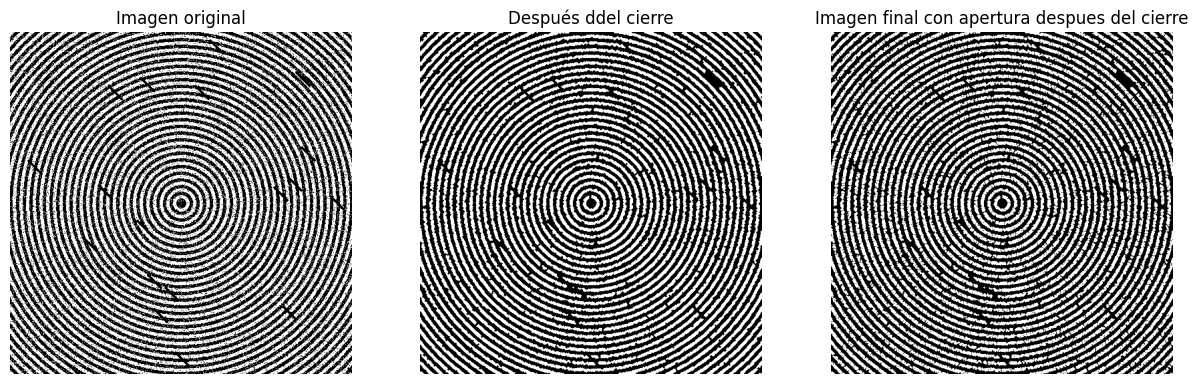

In [2431]:


img = cv2.imread('fingerprint_noisy.png', cv2.IMREAD_GRAYSCALE)
_, img_bin = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # esto asegura que sea binaria 

# Elemento estructurante
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))


# Cierre (conecta grietas)
img_open = cv2.morphologyEx(img_open, cv2.MORPH_CLOSE, kernel)
# Apertura (elimina ruido sal)
img_final = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernel)


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_bin, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_open, cmap='gray')
plt.title('Después ddel cierre')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_final, cmap='gray')
plt.title('Imagen final con apertura despues del cierre')
plt.axis('off')

plt.show()


In [2432]:
plt.figure(figsize=(20,10))

plt.imshow(img_final, cmap='gray')
plt.title('Imagen final con apertura despues del cierre')
plt.axis('off')

plt.show()

Se muestran ambos resultados, el primero siento el orden correcto se aplica una apertura que limpia el ruido que tiene la imagen original y luego un cierre que se encargar de reparar la imagen. Se escogió la apertura como primer paso debido a que este se encarga de eliminar el ruido tipo sal, pero preserva las estructuras grandes. Esto es importante porque al ser una huella se quiere perder la menor cantidad de información posible. Luego el cierre se aplica porque este se encarga de conectar pequeñas grietas en las crestas y mantiene el grosor original, lo cual nos ayuda a mantener la imagen de la huella. 

En caso se quiera aplicar de manera inversa lo que pasaría, como se muestra en la segunda imagen del segundo resultado, es que el cierre aumentaría el ruido tipo sal y los puntos crecen en vez de desaparecer, lo que ocurre que se mezcle con parte de la estructura y deje de ser ruido como tal. Una vez suceda esta mezcla, al aplicar la apertura ya no limpia estas áreas que se juntaron porque ya no las reconoce como ruido, si no parte de la estructura. Y esto se puede ver de manera muy sutil entre los dos resultados, donde la primera imagen se ve muchisimo más clara a comparación de la segunda que tiene bastantes alteraciones en la parte blanca de la huella. 

# Task 3

Una fábrica textil necesita detectar rasgaduras en telas de mezclilla (denim) automáticamente. El problema es que la tela tiene una textura natural fuerte (patrón repetitivo) que confunde a los detectores de bordes simples (Canny), detectando el tejido como si fuera un defecto. Por ello se le pide que usted diseñe un pipeline híbrido que combine Fourier y Morfología para aislar solamente la rasgadura. Para ello comienza por probar su solución en una imagen que tiene a mano

Con esto en mente, realice:
1. Utilice Fourier para analizar la textura repetitiva de la tela. Diseñe un filtro que elimine las
frecuencias altas/repetitivas del tejido, dejando una imagen "suavizada" donde solo resalte la
anomalía (la rasgadura) y la iluminación global. (Supresión de Textura)
a. Hint: ¿Qué pasa si eliminamos las frecuencias altas periféricas o específicas?

In [2433]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

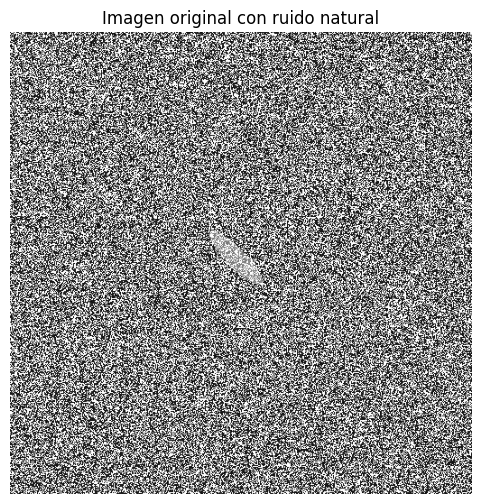

In [2434]:
img = cv2.imread('textile_defect.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')
plt.title('Imagen original con ruido natural')
plt.axis('off')

In [2435]:
# Transformada
transform = np.fft.fft2(img)
# Shift (centra)
shifted = np.fft.fftshift(transform)

# Mascara
rows, cols = img.shape
crow, ccol = rows // 2, cols // 2
mask = np.zeros((rows, cols), np.uint8)
radius = 10
cv2.circle(mask, (ccol, crow), radius, 1, -1)

# Frecuencias altas
high_freq = shifted * (1 - mask)
f_ishift = np.fft.ifftshift(high_freq) # inversa
noise_estimate = np.abs(np.fft.ifft2(f_ishift)) # valor absoluto

# Substraccion de altas frecuencias
denoised = img - noise_estimate
denoised = np.clip(denoised, 0, 255).astype(np.uint8)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original")
ax[0].set_axis_off()

ax[1].imshow(denoised, cmap='gray')
ax[1].set_title("- Frecuencias Altas")
ax[1].set_axis_off()

plt.show()


2. Aplique un umbralizado (thresholding) a la imagen resultante del paso 1 para obtener una máscara
binaria preliminar. (Segmentación)

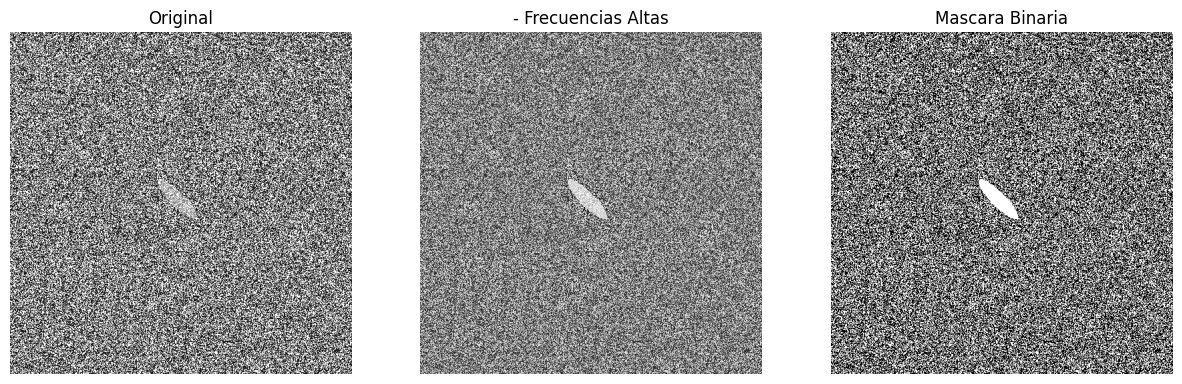

In [2436]:
# Umbral automatico con cv2
_, bin_mask = cv2.threshold(
    denoised, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original")
ax[0].set_axis_off()

ax[1].imshow(denoised, cmap='gray')
ax[1].set_title("- Frecuencias Altas")
ax[1].set_axis_off()

ax[2].imshow(bin_mask, cmap='gray')
ax[2].set_title("Mascara Binaria")
ax[2].set_axis_off()
plt.show()

3. La máscara seguramente tendrá ruido residual. Utilice operaciones morfológicas para limpiar la
máscara y dejar únicamente la silueta de la rasgadura. (Refinamiento)

In [2437]:
# Kernel con cv2
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
eroded = cv2.erode(bin_mask, kernel, iterations=1)
opened = cv2.morphologyEx(
    bin_mask,
    cv2.MORPH_OPEN,
    kernel
)

# ax
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].imshow(img)
ax[0].set_title("Original")
ax[0].set_axis_off()

ax[1].imshow(eroded)
ax[1].set_title("Erosion")
ax[1].set_axis_off()

ax[2].imshow(opened)
ax[2].set_title("Open (Erosion -> dilatacion)")
ax[2].set_axis_off()



plt.show()